## Use TF to solve 2D Poisson's equation

In [1]:
import tensorflow as tf
import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs

np.random.seed(1234)
tf.set_random_seed(1234)
%matplotlib inline

## Formulation

- Poisson Equation
$$\nabla^2P = f$$

Boundary conditions:

- Dirichlet: $P =$ certain value at boundaries

- Neumann: $\partial P = $ certain value at boundaries

useful for Gaussian field (gravitational field, electrostatics)

pressure distribution for incompressible reservoir simulation
    


In [2]:
class NN_Poisson_Solver:
    # Initialize the class
    def __init__(self, XY_b, P_b, XY_F, layers, lb, ub):
        """
            XY_b, P_b: where to enforece boundary condition. XY_b is a nx2 array (x and y), P_b is 1D array
            XY_f: where to enforce physics equations

        """
        
        self.lb = lb
        self.ub = ub
    
        self.x_b = XY_b[:,0:1]
        self.y_b = XY_b[:,1:2]
        self.p_b = P_b
        
        self.x_f = XY_f[:,0:1]
        self.y_f = XY_f[:,1:2]
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_b_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.p_b_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.p_pred = self.net_u(self.x_b_tf, self.y_b_tf)
        self.f_pred = self.net_f(self.x_f_tf, self.y_f_tf)
        
        self.loss_b  = tf.reduce_mean(tf.square(self.p_pred - self.p_b_tf)) #enforce boundary condition
        
        self.loss_f = tf.reduce_mean(tf.square(self.f_pred))

        self.loss = self.loss_b+ self.loss_f
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 1000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 2.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = 0.0002)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XY, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XY - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        P = tf.add(tf.matmul(H, W), b)
        
        return P
    
    def net_u(self, x, y):
        u = self.neural_net(tf.concat([x,y],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, y):
        p = self.net_u(x,y)
        
        px  = tf.gradients(p,x)[0]
        pxx = tf.gradients(px,x)[0]
        
        py  = tf.gradients(p,y)[0]
        pyy = tf.gradients(py,y)[0]
        
        f =  1.0*tf.exp(-100.0*(tf.pow(x-0.0,2)+tf.pow(y-0.0,2))) \
            + 2.0*tf.exp(-100.0*(tf.pow(x+0.4,2)+tf.pow(y-0.0,2))) \
            - 1.0*tf.exp(-100.0*(tf.pow(x-0.4,2)+tf.pow(y+0.0,2))) \
            - 2.0*tf.exp(-100.0*(tf.pow(x+0.0,2)+tf.pow(y+0.5,2)))

        eqn = pxx + pyy - f
        
        return eqn
    
    def callback(self, loss, loss_b, loss_f):
        self.iter += 1
        if (self.iter % 50 == 0):
            print('Iter: %05d, Loss: %.2e, b: %.3e, f: %.3e' % \
                  (self.iter,  loss, loss_b, loss_f))
        
    def train(self, nIter_adam):

        tf_dict = {self.x_b_tf: self.x_b, self.y_b_tf: self.y_b, self.p_b_tf : self.p_b,
                   self.x_f_tf: self.x_f, self.y_f_tf: self.y_f}
        
        start_t= time.time()

        # train with Adam
        for it in range(nIter_adam):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_t
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,  elapsed))
                start_t = time.time()
        
        # train with BFGS
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_b, self.loss_f], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XY):
        p = self.sess.run(self.p_pred, {self.x_b_tf:XY[:,0:1], self.y_b_tf:XY[:,1:2]})
        f = self.sess.run(self.f_pred, {self.x_f_tf:XY[:,0:1], self.y_f_tf:XY[:,1:2]})
        
        return p, f

In [3]:
def draw_prediction():

    x_star = np.linspace(-1,1,129)
    y_star = np.linspace(-1,1,129)
    X_star, Y_star = np.meshgrid(x_star, y_star)
    XY_star = np.c_[X_star.flatten(),Y_star.flatten()]

    p, f = model.predict(XY_star)
    p_pred = p.reshape(X_star.shape)
    f_pred = f.reshape(X_star.shape)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(221)
    plt.pcolor(X_star, Y_star, p_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('p')
    
    ax = fig.add_subplot(222)
    plt.pcolor(X_star, Y_star, f_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('equation')
    
    ax = fig.add_subplot(223)
    plt.pcolor(Xtrue, Ytrue, Ptrue, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('true numerical solution')
    
    ax = fig.add_subplot(224)
    plt.pcolor(X_star, Y_star, p_pred-Ptrue,cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.title('delta')
    
    plt.show()
    

In [4]:
def Solve_2D_Poisson_Numerical(n = 129):
    """
        solving 2D Poisson's equation in [-1,1]^2 domain numerically
        
    """
    
    from scipy import sparse
    
    nx = ny = n
    x = np.linspace(-1,1,nx)
    y = np.linspace(-1,1,ny)
    X, Y = np.meshgrid(x, y)
    
    dx = x[1]-x[0]
    N = nx*ny
    
    X1D, Y1D = X.flatten(),Y.flatten()
    
    RHS =   1.0*np.exp(-100.0*(np.square(X1D-0.0)+np.square(Y1D-0.0))) \
          + 2.0*np.exp(-100.0*(np.square(X1D+0.4)+np.square(Y1D-0.0))) \
          - 1.0*np.exp(-100.0*(np.square(X1D-0.4)+np.square(Y1D+0.0))) \
          - 2.0*np.exp(-100.0*(np.square(X1D+0.0)+np.square(Y1D+0.5)))
    RHS = RHS.reshape((N,1))
    
    #Laplacian Operator
    main_diag  = -4.0*np.ones(N)
    left_diag  = 1.0*np.ones(N-1)
    right_diag = 1.0*np.ones(N-1)
    up_diag    = 1.0*np.ones(N-nx)
    down_diag  = 1.0*np.ones(N-nx)
    
    diagonals = [main_diag, left_diag, right_diag, up_diag, down_diag]
    
    laplacian = sparse.diags(diagonals,[0,-1,1,nx,-nx], format = 'csc')
    
    sol = sparse.linalg.spsolve(laplacian, RHS.reshape(N,1))*dx*dx
    
    return X, Y, sol.reshape(X.shape)
    

In [5]:
Xtrue, Ytrue, Ptrue = Solve_2D_Poisson_Numerical(129)

## Training Neural Net with Initial & Boundary Condition and Physics Laws

In [6]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 1024 #number of points to enforce on physics

layers = [2, 32, 32, 32, 32, 32, 32, 1]
#layers = [3, 128, 128, 64, 64, 64, 32, 32, 32, 3]

x = np.linspace(-1,1,N_b)
y = np.linspace(-1,1,N_b)

X, Y = np.meshgrid(x, y)


#### Boundary conditions (Dirichlet)

In [7]:
LeftB = np.c_[X[:,0].flatten(),Y[:,0].flatten()]
RightB = np.c_[X[:,-1].flatten(),Y[:,-1].flatten()]
TopB = np.c_[X[0,:].flatten(),Y[0,:].flatten()]
BotB = np.c_[X[-1,:].flatten(),Y[-1,:].flatten()]

XY_b = np.r_[LeftB,RightB,TopB,BotB]
P_b = np.zeros((XY_b.shape[0],1))

#### Collocation point (where to reinforce physics)

In [8]:
lb = np.array([x.min(),y.min()])
ub = np.array([x.max(),y.max()])

XY_f = lb + (ub-lb)*lhs(2, N_f)

In [9]:
## Visualize points

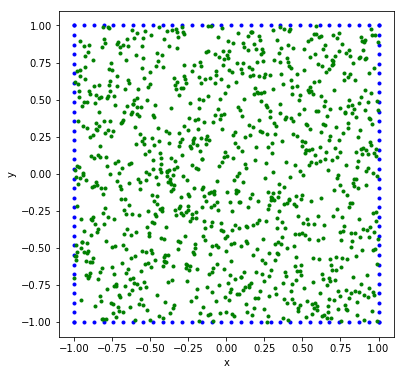

In [10]:
plt.figure(figsize=(6,6))

plt.plot(XY_b[:,0],XY_b[:,1],'b.')
plt.plot(XY_f[:,0],XY_f[:,1],'g.')

plt.xlabel('x')
plt.ylabel('y')


In [11]:
model = NN_Poisson_Solver(XY_b,P_b, XY_f, layers, lb, ub)

C:\Users\xiang.zhai\AppData\Local\Continuum\Miniconda2\envs\ML\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Iter: 00050, Loss: 4.16e-02, b: 7.966e-05, f: 4.149e-02
Iter: 00100, Loss: 2.02e-02, b: 1.281e-04, f: 2.010e-02
Iter: 00150, Loss: 1.42e-02, b: 2.247e-05, f: 1.414e-02
Iter: 00200, Loss: 9.40e-03, b: 4.612e-05, f: 9.353e-03
Iter: 00250, Loss: 7.62e-03, b: 2.748e-05, f: 7.588e-03
Iter: 00300, Loss: 6.29e-03, b: 7.168e-05, f: 6.217e-03
Iter: 00350, Loss: 4.88e-03, b: 5.058e-05, f: 4.831e-03
Iter: 00400, Loss: 3.51e-03, b: 6.009e-05, f: 3.449e-03
Iter: 00450, Loss: 2.27e-03, b: 2.747e-05, f: 2.241e-03
Iter: 00500, Loss: 1.62e-03, b: 2.856e-05, f: 1.592e-03
Iter: 00550, Loss: 1.26e-03, b: 2.089e-05, f: 1.244e-03
Iter: 00600, Loss: 1.05e-03, b: 1.418e-05, f: 1.038e-03
Iter: 00650, Loss: 8.44e-04, b: 9.357e-06, f: 8.349e-04
Iter: 00700, Loss: 6.26e-04, b: 8.877e-06, f: 6.167e-04
Iter: 00750, Loss: 5.12e-04, b: 6.112e-06, f: 5.055e-04
Iter: 00800, Loss: 4.50e-04, b: 5.664e-06, f: 4.441e-04
Iter: 00850, Loss: 4.08e-04, b: 5.726e-06, f: 4.023e-04
Iter: 00900, Loss: 3.61e-04, b: 4.903e-06, f: 3.

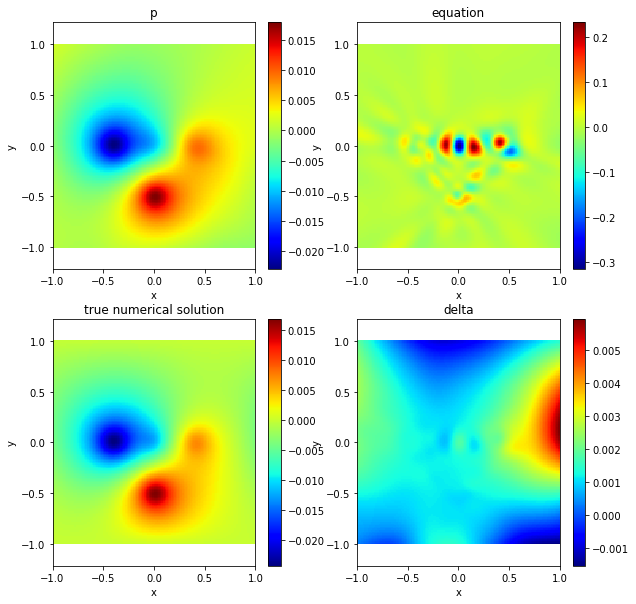

Iter: 00050, Loss: 2.29e-04, b: 1.536e-06, f: 2.274e-04
Iter: 00100, Loss: 2.04e-04, b: 1.621e-06, f: 2.020e-04
Iter: 00150, Loss: 1.69e-04, b: 3.250e-06, f: 1.658e-04
Iter: 00200, Loss: 1.35e-04, b: 2.385e-06, f: 1.328e-04
Iter: 00250, Loss: 1.15e-04, b: 1.726e-06, f: 1.134e-04
Iter: 00300, Loss: 9.83e-05, b: 1.298e-06, f: 9.700e-05
Iter: 00350, Loss: 8.08e-05, b: 1.670e-06, f: 7.914e-05
Iter: 00400, Loss: 6.37e-05, b: 2.146e-06, f: 6.157e-05
Iter: 00450, Loss: 5.49e-05, b: 1.937e-06, f: 5.292e-05
Iter: 00500, Loss: 4.72e-05, b: 1.701e-06, f: 4.551e-05
Iter: 00550, Loss: 4.13e-05, b: 1.200e-06, f: 4.007e-05
Iter: 00600, Loss: 3.49e-05, b: 1.458e-06, f: 3.346e-05
Iter: 00650, Loss: 3.00e-05, b: 1.216e-06, f: 2.883e-05
Iter: 00700, Loss: 2.69e-05, b: 1.170e-06, f: 2.573e-05
Iter: 00750, Loss: 2.42e-05, b: 1.093e-06, f: 2.307e-05
Iter: 00800, Loss: 2.15e-05, b: 9.573e-07, f: 2.057e-05
Iter: 00850, Loss: 1.97e-05, b: 7.677e-07, f: 1.889e-05
Iter: 00900, Loss: 1.82e-05, b: 7.623e-07, f: 1.

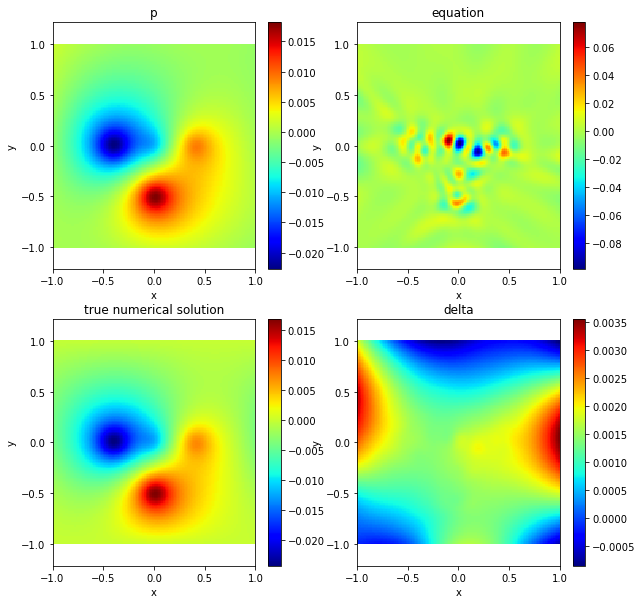

Iter: 00050, Loss: 1.32e-05, b: 6.420e-07, f: 1.251e-05
Iter: 00100, Loss: 1.26e-05, b: 6.471e-07, f: 1.195e-05
Iter: 00150, Loss: 1.22e-05, b: 6.214e-07, f: 1.160e-05
Iter: 00200, Loss: 1.17e-05, b: 6.085e-07, f: 1.113e-05
Iter: 00250, Loss: 1.13e-05, b: 5.940e-07, f: 1.074e-05
Iter: 00300, Loss: 1.09e-05, b: 6.296e-07, f: 1.029e-05
Iter: 00350, Loss: 1.06e-05, b: 6.194e-07, f: 1.001e-05
Iter: 00400, Loss: 1.02e-05, b: 5.742e-07, f: 9.586e-06
Iter: 00450, Loss: 9.64e-06, b: 5.502e-07, f: 9.087e-06
Iter: 00500, Loss: 9.10e-06, b: 5.060e-07, f: 8.598e-06
Iter: 00550, Loss: 8.66e-06, b: 5.051e-07, f: 8.152e-06
Iter: 00600, Loss: 8.19e-06, b: 5.014e-07, f: 7.690e-06
Iter: 00650, Loss: 7.72e-06, b: 4.813e-07, f: 7.237e-06
Iter: 00700, Loss: 7.38e-06, b: 4.253e-07, f: 6.954e-06
Iter: 00750, Loss: 6.97e-06, b: 3.892e-07, f: 6.583e-06
Iter: 00800, Loss: 6.62e-06, b: 3.628e-07, f: 6.260e-06
Iter: 00850, Loss: 6.38e-06, b: 3.689e-07, f: 6.013e-06
Iter: 00900, Loss: 6.18e-06, b: 3.637e-07, f: 5.

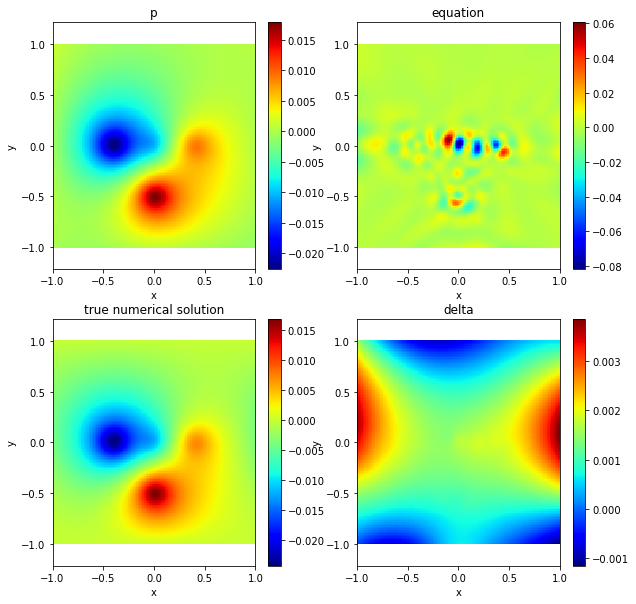

Iter: 00050, Loss: 5.41e-06, b: 3.404e-07, f: 5.069e-06
Iter: 00100, Loss: 5.31e-06, b: 3.497e-07, f: 4.961e-06
Iter: 00150, Loss: 5.23e-06, b: 3.451e-07, f: 4.881e-06
Iter: 00200, Loss: 5.14e-06, b: 3.348e-07, f: 4.804e-06
Iter: 00250, Loss: 5.05e-06, b: 3.322e-07, f: 4.713e-06
Iter: 00300, Loss: 4.96e-06, b: 3.410e-07, f: 4.620e-06
Iter: 00350, Loss: 4.87e-06, b: 3.392e-07, f: 4.535e-06
Iter: 00400, Loss: 4.80e-06, b: 3.431e-07, f: 4.460e-06
Iter: 00450, Loss: 4.72e-06, b: 3.394e-07, f: 4.382e-06
Iter: 00500, Loss: 4.65e-06, b: 3.365e-07, f: 4.313e-06
Iter: 00550, Loss: 4.57e-06, b: 3.404e-07, f: 4.234e-06
Iter: 00600, Loss: 4.48e-06, b: 3.419e-07, f: 4.134e-06
Iter: 00650, Loss: 4.39e-06, b: 3.478e-07, f: 4.042e-06
Iter: 00700, Loss: 4.32e-06, b: 3.487e-07, f: 3.974e-06
Iter: 00750, Loss: 4.24e-06, b: 3.427e-07, f: 3.901e-06
Iter: 00800, Loss: 4.19e-06, b: 3.375e-07, f: 3.851e-06
Iter: 00850, Loss: 4.13e-06, b: 3.407e-07, f: 3.788e-06
Iter: 00900, Loss: 4.04e-06, b: 3.366e-07, f: 3.

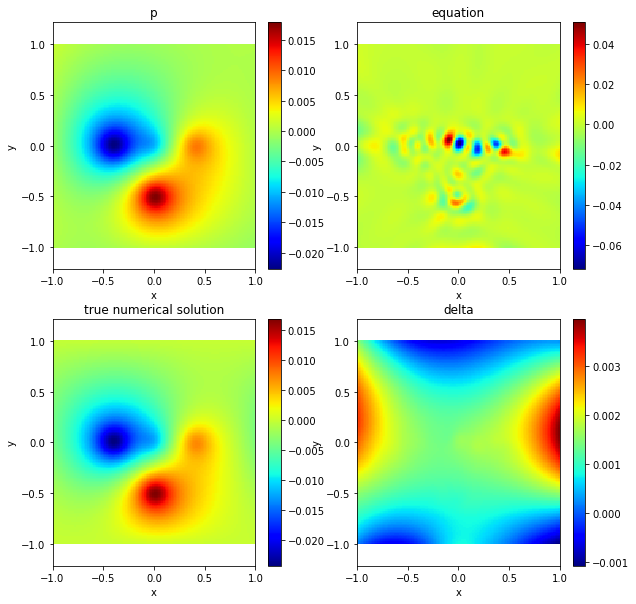

Iter: 00050, Loss: 3.63e-06, b: 3.251e-07, f: 3.307e-06
Iter: 00100, Loss: 3.58e-06, b: 3.189e-07, f: 3.259e-06
Iter: 00150, Loss: 3.52e-06, b: 3.183e-07, f: 3.205e-06
Iter: 00200, Loss: 3.47e-06, b: 3.200e-07, f: 3.146e-06
Iter: 00250, Loss: 3.42e-06, b: 3.199e-07, f: 3.105e-06
Iter: 00300, Loss: 3.40e-06, b: 3.166e-07, f: 3.079e-06
Iter: 00350, Loss: 3.36e-06, b: 3.134e-07, f: 3.044e-06
Iter: 00400, Loss: 3.32e-06, b: 3.154e-07, f: 3.001e-06
Iter: 00450, Loss: 3.28e-06, b: 3.180e-07, f: 2.967e-06
Iter: 00500, Loss: 3.24e-06, b: 3.149e-07, f: 2.929e-06
Iter: 00550, Loss: 3.23e-06, b: 3.166e-07, f: 2.910e-06
Iter: 00600, Loss: 3.20e-06, b: 3.117e-07, f: 2.887e-06
Iter: 00650, Loss: 3.16e-06, b: 3.058e-07, f: 2.853e-06
Iter: 00700, Loss: 3.13e-06, b: 3.112e-07, f: 2.814e-06
Iter: 00750, Loss: 3.10e-06, b: 3.061e-07, f: 2.793e-06
Iter: 00800, Loss: 3.07e-06, b: 3.081e-07, f: 2.759e-06
Iter: 00850, Loss: 3.02e-06, b: 3.104e-07, f: 2.714e-06
Iter: 00900, Loss: 2.98e-06, b: 3.059e-07, f: 2.

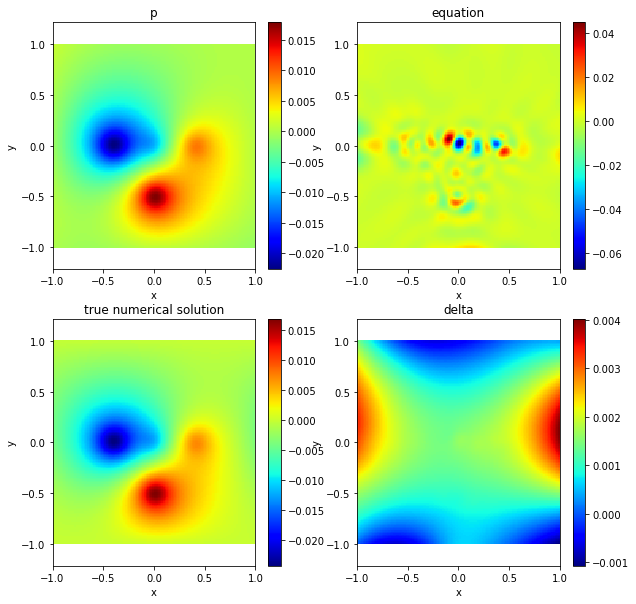

Iter: 00050, Loss: 2.81e-06, b: 2.995e-07, f: 2.509e-06
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 48
  Number of functions evaluations: 52
Training time: 0.9706


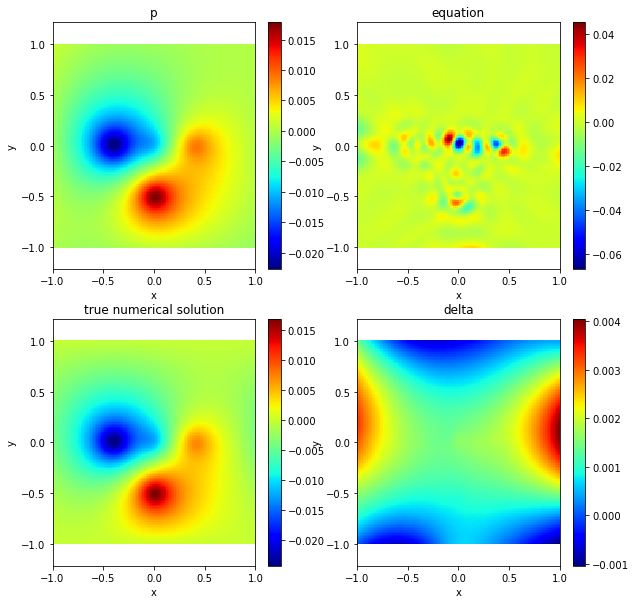

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 0
  Number of functions evaluations: 1
Training time: 0.0311


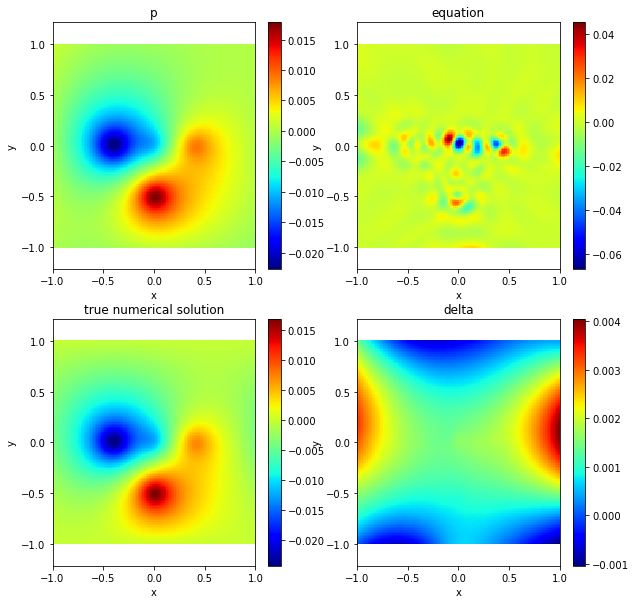

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 0
  Number of functions evaluations: 1
Training time: 0.0341


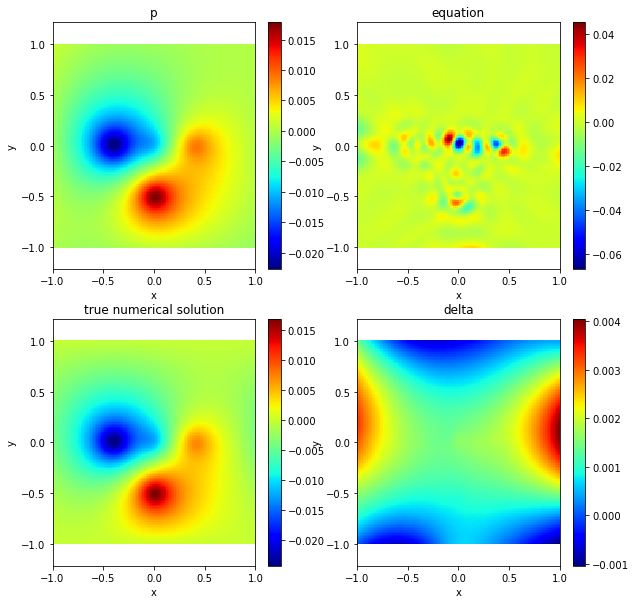

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 0
  Number of functions evaluations: 1
Training time: 0.0291


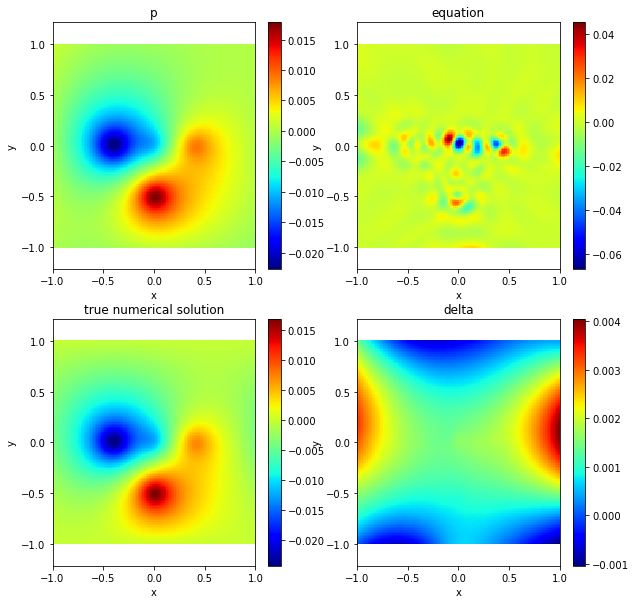

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 0.000003
  Number of iterations: 0
  Number of functions evaluations: 1
Training time: 0.0341


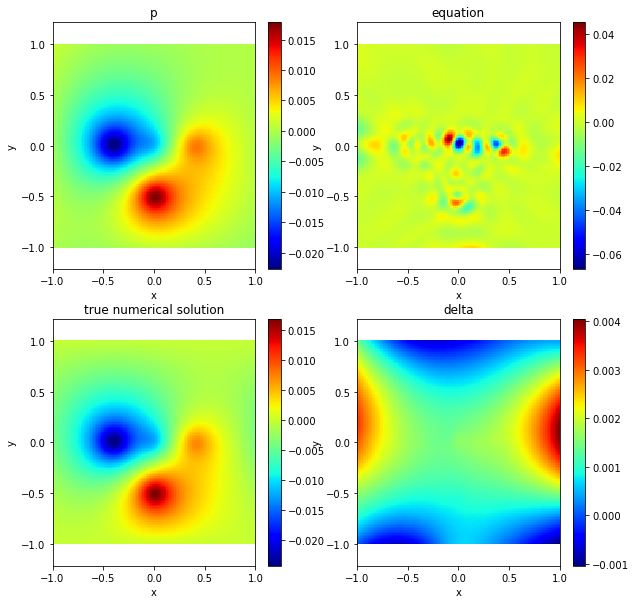

In [12]:
for i in range(10):
    start_time = time.time()
    model.train(0)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    draw_prediction()